<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/341_example_prop.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

# Analisi bayesiana dell'odds-ratio

In questo capitolo, esploreremo l'applicazione degli strumenti statistici descritti nei capitoli precedenti all'analisi bayesiana di due proporzioni. Inizieremo definendo i concetti di odds, odds ratio e logit. Successivamente, mostreremo come effettuare l'analisi bayesiana per il confronto tra due proporzioni.

In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pymc as pm
import pymc.sampling_jax
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 300

## Odds

Il termine "odds" rappresenta il rapporto tra la probabilità che un evento si verifichi e la probabilità che l'evento opposto si verifichi. Matematicamente, l'odds può essere calcolato come:

$$ \text{odds} = \frac{\pi}{1-\pi}, $$

dove $\pi$ rappresenta la probabilità dell'evento di interesse.

Mentre una probabilità $\pi$ è sempre compresa tra 0 e 1, gli odds possono variare da 0 a infinito. Per comprendere meglio gli odds lungo questo spettro, consideriamo tre diversi scenari in cui $\pi$ rappresenta la probabilità di un evento.

Se la probabilità di un evento è $\pi = \frac{2}{3}$, allora la probabilità che l'evento non si verifichi è $1 - \pi = \frac{1}{3}$ e gli odds del verificarsi dell'evento sono:

$$ \text{odds} = \frac{2/3}{1-2/3} = 2. $$

Questo significa che la probabilità che l'evento si verifichi è il doppio della probabilità che non si verifichi.

Se, invece, la probabilità dell'evento è $\pi = \frac{1}{3}$, allora gli odds che l'evento si verifichi sono la metà rispetto agli odds che non si verifichi:

$$ \text{odds} = \frac{1/3}{1-1/3} = \frac{1}{2}. $$

Infine, se la probabilità dell'evento è $\pi = \frac{1}{2}$, allora gli odds dell'evento sono pari a 1:

$$ \text{odds} = \frac{1/2}{1-1/2} = 1. $$

### Interpretazione

Gli odds possono essere interpretati nel modo seguente. Consideriamo un evento di interesse con probabilità $\pi \in [0, 1]$ e gli odds corrispondenti $\frac{\pi}{1-\pi} \in [0, \infty)$. Confrontando gli odds con il valore 1, possiamo ottenere una prospettiva sull'incertezza dell'evento:

- Gli odds di un evento sono inferiori a 1 se e solo se le probabilità dell'evento sono inferiori al 50-50, cioè $\pi < 0.5$.
- Gli odds di un evento sono uguali a 1 se e solo se le probabilità dell'evento sono del 50-50, cioè $\pi = 0.5$.
- Gli odds di un evento sono superiori a 1 se e solo se le probabilità dell'evento sono superiori al 50-50, cioè $\pi > 0.5$.

Uno dei motivi per preferire l'uso dell'odds rispetto alla probabilità, nonostante quest'ultima sia un concetto più intuitivo, risiede nel fatto che quando le probabilità si avvicinano ai valori estremi (cioè 0 o 1), è più facile rilevare e apprezzare le differenze tra gli odds piuttosto che le differenze tra le probabilità.

## Odds Ratio

Quando abbiamo una variabile di interesse espressa come proporzione, possiamo confrontare i gruppi utilizzando l'odds ratio. L'odds ratio rappresenta il rapporto tra gli odds di un evento in un gruppo e gli odds dello stesso evento in un secondo gruppo:

$$ OR = \frac{odds_1}{odds_2} = \frac{p_1/(1-p_1)}{p_2/(1-p_2)}. $$

Interpretazione:

- OR = 1: l'appartenenza al gruppo non influenza il risultato;
- OR > 1: l'appartenenza al gruppo specificato al numeratore dell'OR aumenta la probabilità dell'evento rispetto al gruppo specificato al denominatore;
- OR < 1: l'appartenenza al gruppo specificato al numeratore dell'OR riduce la probabilità dell'evento rispetto al gruppo specificato al denominatore.

L'odds ratio è particolarmente utile quando vogliamo confrontare due gruppi e vedere come l'appartenenza a uno di essi influenza la probabilità di un certo evento. Ad esempio, consideriamo uno studio psicologico in cui stiamo valutando l'efficacia di una terapia comportamentale per ridurre l'ansia. Possiamo suddividere i partecipanti allo studio in due gruppi: quelli che sono stati sottoposti al trattamento (gruppo di trattamento) e quelli che non sono stati sottoposti al trattamento (gruppo di controllo).

Calcolando l'odds ratio tra il gruppo di trattamento e il gruppo di controllo, possiamo capire se la terapia ha aumentato o ridotto la probabilità di riduzione dell'ansia. Se l'odds ratio è maggiore di 1, significa che la terapia ha aumentato le probabilità di riduzione dell'ansia; se è inferiore a 1, significa che il trattamento ha ridotto le probabilità di riduzione dell'ansia. L'odds ratio ci fornisce quindi una misura dell'effetto della terapia rispetto al controllo.

## Logaritmo dell'Odds Ratio

Il logaritmo dell'odds ratio è una trasformazione matematica molto utilizzata nell'analisi statistica, specialmente nella regressione logistica. Essa permette di rendere l'odds ratio interpretabile su una scala lineare, semplificando l'analisi e l'interpretazione dei risultati.

La formula per calcolare il logaritmo dell'odds ratio è la seguente:

$$ \text{logit}(OR) = \log(OR) = \log\left(\frac{odds_1}{odds_2}\right). $$

In altre parole, il logaritmo dell'odds ratio è il logaritmo naturale del rapporto tra gli odds di un evento nel primo gruppo e gli odds dello stesso evento nel secondo gruppo.

### Interpretazione

L'interpretazione del logaritmo dell'odds ratio è più intuitiva rispetto all'odds ratio stesso. Una variazione di una unità nel logaritmo dell'odds ratio corrisponde a un cambiamento costante nell'odds ratio stesso.

Se il logaritmo dell'odds ratio è positivo, significa che l'odds dell'evento nel primo gruppo è maggiore rispetto al secondo gruppo. Più il valore del logaritmo dell'odds ratio si avvicina a zero, più l'odds dell'evento nei due gruppi si avvicina a essere simile.

Se, invece, il logaritmo dell'odds ratio è negativo, l'odds dell'evento nel primo gruppo è inferiore rispetto al secondo gruppo. Un valore di logaritmo dell'odds ratio vicino a zero indica che l'odds dell'evento è simile nei due gruppi.

### Utilizzo nella regressione logistica

Nella regressione logistica, i coefficienti dei predittori sono espressi come logaritmi dell'odds ratio. Questa rappresentazione lineare dei coefficienti semplifica la modellazione e l'interpretazione dei risultati.

Ad esempio, supponiamo di avere un modello di regressione logistica con un singolo predittore binario $X$, e il coefficiente stimato per $X$ è $\beta_1 = 0.50$. Questo significa che il logaritmo dell'odds ratio per $X$ è $\log(OR) = 0.50$. Per interpretare questo valore, dobbiamo esponenziarlo:

$$ OR = e^{0.50} \approx 1.65. $$

Questo ci dice che la probabilità dell'evento di interesse nel gruppo con $X = 1$ è circa 1.65 volte più grande rispetto al gruppo con $X = 0$. Se il valore del logaritmo dell'odds ratio fosse stato negativo, avremmo concluso che l'odds dell'evento nel gruppo con $X = 1$ è più piccolo rispetto al gruppo con $X = 0$.

## Analisi bayesiana delle proporzioni

Una volta compresi i concetti di odds, odds ratio e logit, possiamo procedere all'analisi bayesiana delle proporzioni. Questo approccio ci consente di confrontare le proporzioni di due gruppi e ottenere stime delle probabilità a posteriori e degli intervalli di credibilità.

L'analisi bayesiana si basa sull'applicazione del teorema di Bayes per aggiornare le nostre conoscenze a priori con l'evidenza fornita dai dati osservati. Questo ci permette di ottenere una distribuzione a posteriori delle quantità di interesse, come l'odds ratio.

In questo tutorial, analizzeremo i dati riguardanti i voti del primo parziale di Psicometria dell'anno accademico 2022-2023, suddividendo gli studenti per genere (femmine e maschi). Ci concentreremo sull'evento dicotomico relativo a "aver impiegato un tempo maggiore della media per concludere l'esame".

I dati di cui disponiamo sono i seguenti:

- Tra le studentesse, 108 hanno impiegato un tempo maggiore della media su un totale di 155.
- Tra gli studenti maschi, 28 hanno impiegato un tempo maggiore della media su un totale di 57.

Per confrontare le prestazioni dei due gruppi, useremo l'odds ratio, una misura statistica che ci permette di confrontare le probabilità di un evento tra i due gruppi. Il calcolo dell'odds ratio ci aiuterà a determinare se c'è una differenza credibile nelle probabilità tra i due gruppi riguardo a questo evento.

Iniziamo calcolando la probabilità che una femmina impieghi un tempo maggiore della media nel primo parziale di Psicometria:

$$ p_f = \frac{108}{155} \approx 0.6968. $$

Successivamente, calcoliamo gli odds per le femmine:

$$ odds_f = \frac{p_f}{1 - p_f} \approx 2.2979. $$

Questo ci dice che per le femmine ci sono circa due "successi" (ossia impiegare un tempo maggiore della media) per ogni "insuccesso" (impiegare un tempo minore della media).

Procediamo calcolando la probabilità che un maschio impieghi un tempo maggiore della media nel primo parziale di Psicometria:

$$ p_m = \frac{28}{57} \approx 0.4912. $$

Calcoliamo poi gli odds per i maschi:

$$ odds_m = \frac{p_m}{1 - p_m} \approx 0.9655. $$

Questo ci dice che per i maschi c'è circa lo stesso numero di "successi" (ossia impiegare un tempo maggiore della media) e "insuccessi" (impiegare un tempo minore della media).

Infine, confrontiamo gli odds tra le femmine e i maschi per calcolare l'odds ratio (OR):

$$ OR = \frac{odds_f}{odds_m} \approx 2.3799. $$

Un odds ratio di circa 2 ci indica che le femmine hanno circa il doppio delle probabilità di impiegare un tempo maggiore della media rispetto ai maschi nel primo parziale di Psicometria. In altre parole, le femmine tendono ad avere una probabilità più elevata di impiegare un tempo maggiore della media rispetto ai maschi in questo esame. Questa differenza nell'odds di "successo" tra i due gruppi può essere utile per capire le differenze di prestazione tra le studentesse e gli studenti.

## Inferenza bayesiana sull'Odds Ratio

L'Odds Ratio (OR) ci fornisce una descrizione delle differenze osservate nel campione analizzato, in questo caso specifico, un OR di circa 2.38 tra le femmine e i maschi riguardo al tempo impiegato nel primo parziale di Psicometria. Tuttavia, è essenziale considerare la "variabilità campionaria", poiché questo risultato potrebbe variare tra diversi campioni.

Il problema dell'inferenza statistica si pone quando vogliamo conoscere le caratteristiche del fenomeno generale, ovvero ciò che è comune a tutti i campioni (le caratteristiche della popolazione statistica), piuttosto che le caratteristiche specifiche del campione esaminato.

Per rispondere a questa domanda, adotteremo un approccio bayesiano. Costruiremo la distribuzione a posteriori dell'odds ratio e stabiliremo un livello di credibilità, ad esempio 0.9 (cioè 90% di confidenza). Se l'intervallo di credibilità, calcolato a questo livello, non include il valore 1, possiamo affermare con un grado di confidenza del 90% che la differenza osservata tra maschi e femmine nel tempo impiegato nel primo parziale di Psicometria è generalizzabile e rappresenta una caratteristica comune per gli esami di questo tipo.

In altre parole, se l'intervallo di credibilità non include 1, possiamo affermare con una certa sicurezza che la differenza osservata tra i gruppi di maschi e femmine nel tempo impiegato è effettivamente una caratteristica comune per gli esami di questo tipo e non specifica solo di questo particolare campione. Al contrario, se l'intervallo di credibilità includesse il valore 1, avremmo meno prove per sostenere la generalizzabilità di questa differenza e dovremmo considerare il risultato come più specifico di questo particolare campione.

Per calcolare l'intervallo di credibilità al 90% dell'OR useremo PyMC.

In [9]:
n1 = 155
y1 = 108
n2 = 57
y2 = 28

with pm.Model() as model:
    # Define the priors for the two proportions
    p1 = pm.Beta("p1", alpha=2, beta=2)
    p2 = pm.Beta("p2", alpha=2, beta=2)

    # Define the likelihood functions for the two proportions
    likelihood1 = pm.Binomial("likelihood1", n=n1, p=p1, observed=y1)
    likelihood2 = pm.Binomial("likelihood2", n=n2, p=p2, observed=y2)

    # Define the difference of odds model
    odds_ratio = pm.Deterministic("odds_ratio", (p1 / (1 - p1)) / (p2 / (1 - p2)))

Eseguiamo il campionamento.

In [10]:
with model:
    trace = pm.sampling_jax.sample_numpyro_nuts(draws=2000, tune=1000)

Compiling...
Compilation time =  0:00:02.843499
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]







Running chain 3: 100%|██████████| 3000/3000 [00:03<00:00, 808.85it/s]


Sampling time =  0:00:04.156065
Transforming variables...
Transformation time =  0:00:00.116617


## Diagnostica delle catene markoviane

Prima di esaminare i risultati, eseguiamo la diagnostica delle catene markoviane.

### Mixing

Il trace plot precedente dimostra un buon mixing. Questo è evidenza che il campionamento MCMC ha raggiunto uno stato stazionario.


/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_18260/557939814.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


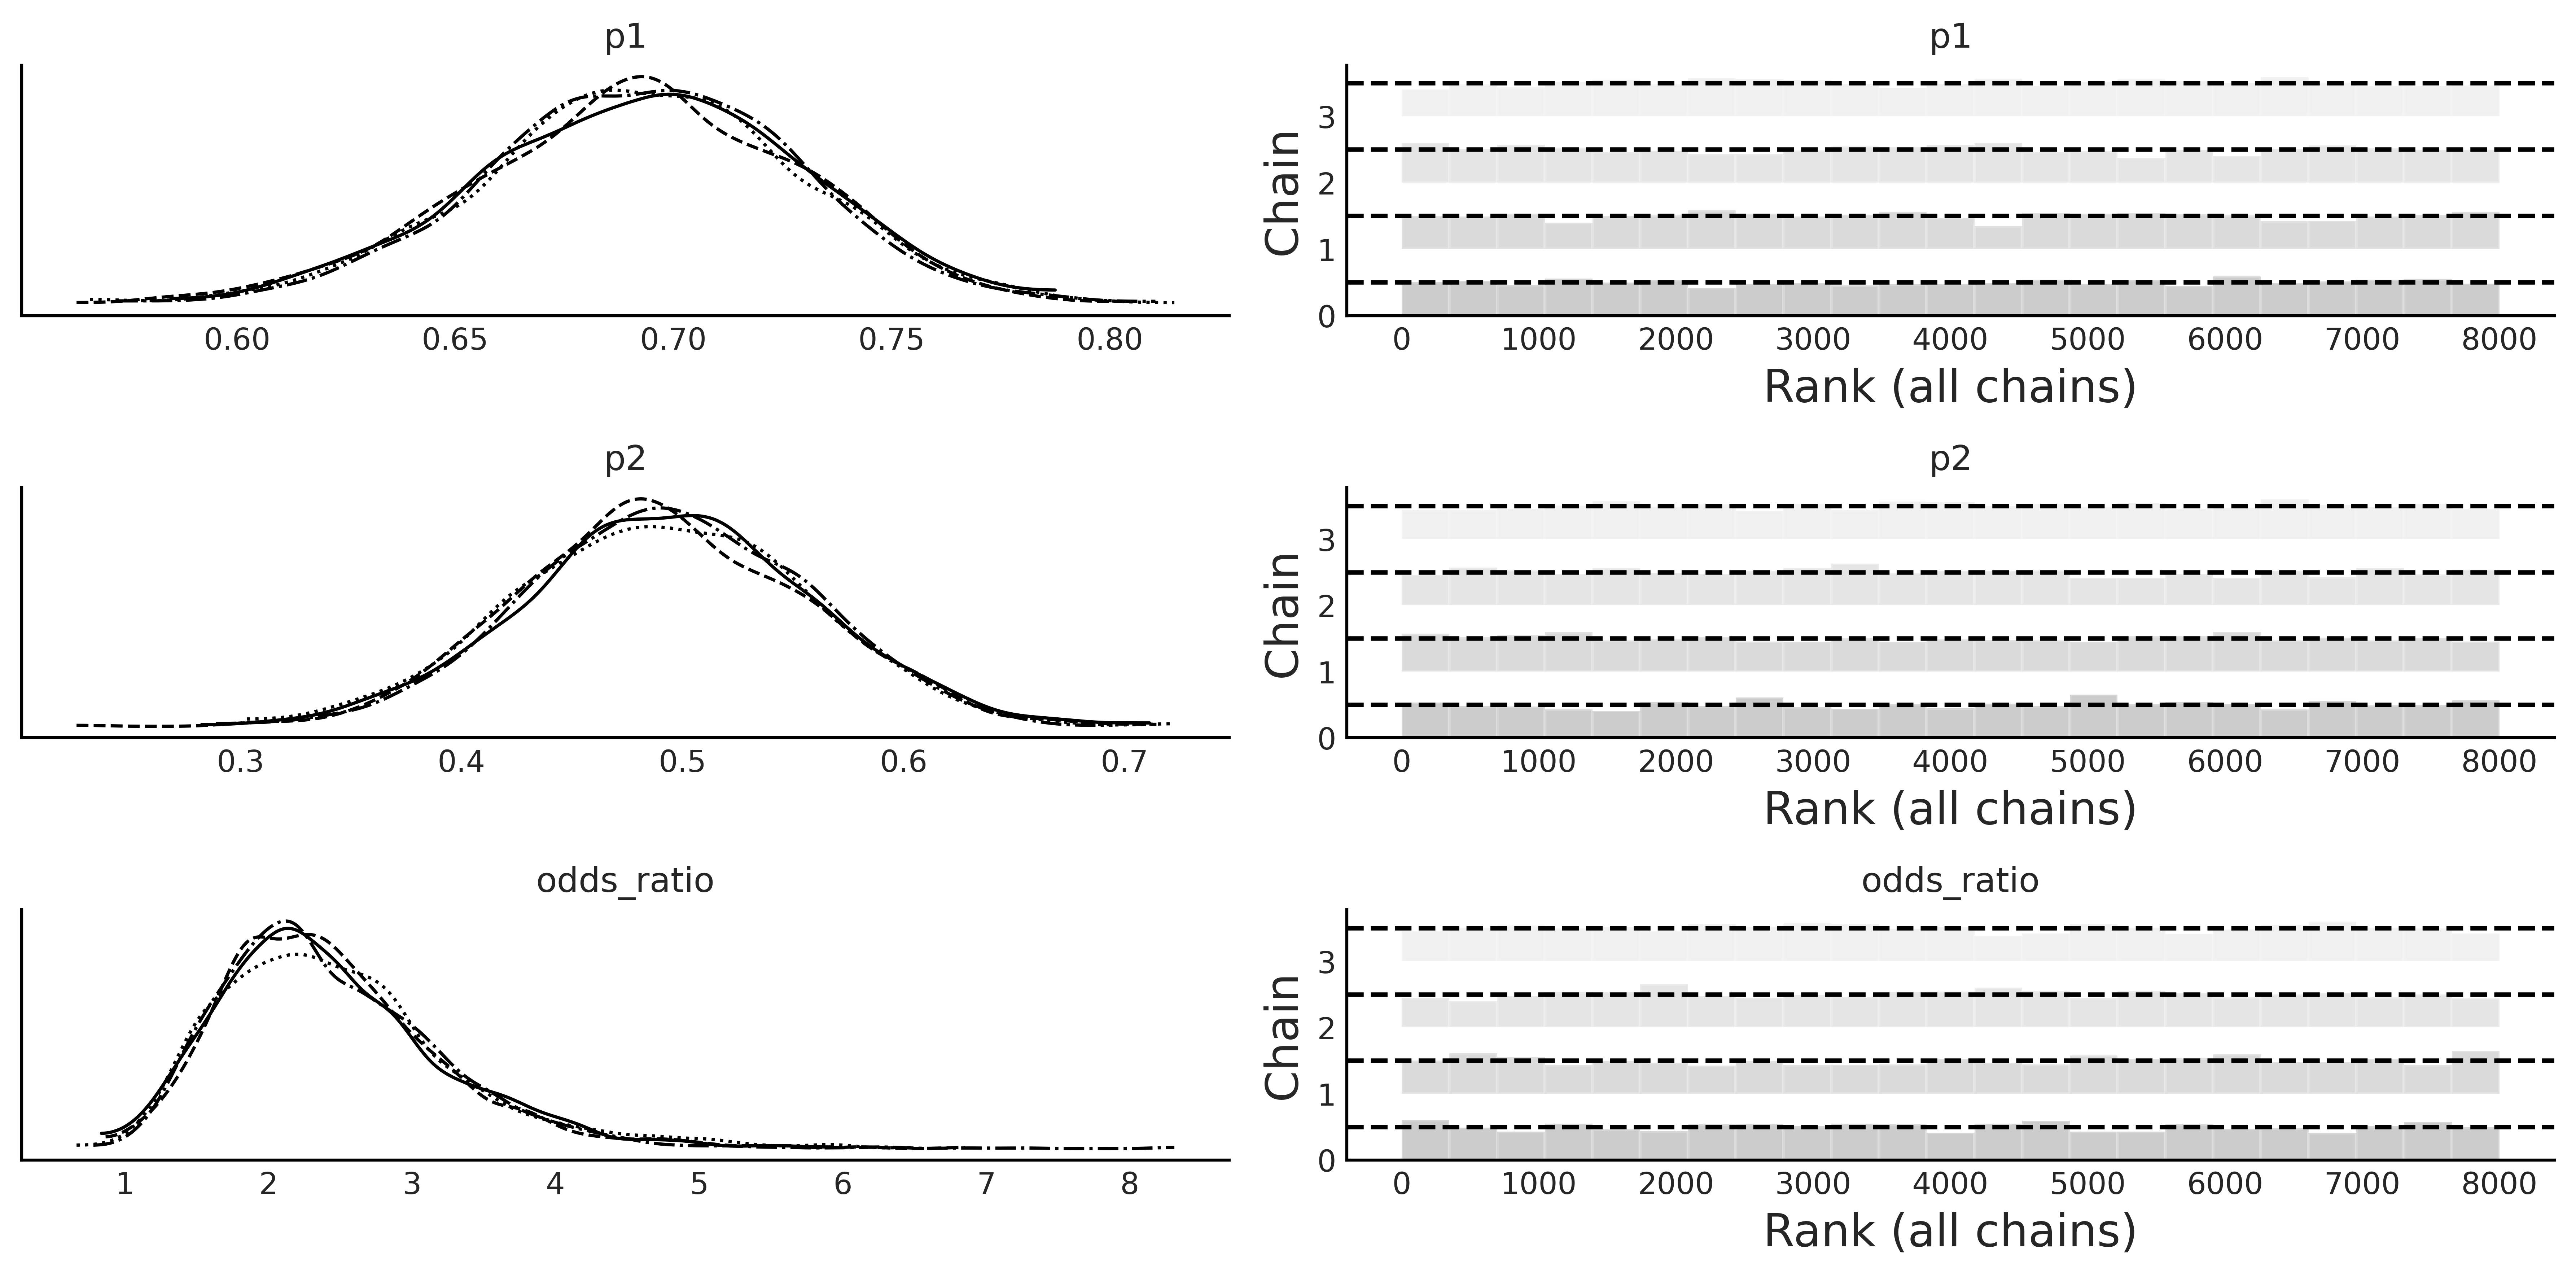

In [22]:
az.plot_trace(trace, kind="rank_bars", figsize=(12, 6))
plt.tight_layout()
plt.show();

### Numerosità campionaria effettiva

Quando si utilizzano metodi di campionamento MCMC, è ragionevole chiedersi se un particolare campione estratto dalla distribuzione a posteriori sia sufficientemente grande per calcolare con sicurezza le quantità di interesse, come una media o un HDI. Questo non è qualcosa che possiamo rispondere direttamente guardando solo il numero di punti della catena MCMC, e il motivo è che i campioni ottenuti dai metodi MCMC hanno un certo grado di autocorrelazione, quindi la quantità effettiva di informazioni contenute in quel campione sarà inferiore a quella che otterremmo da un campione iid della stessa dimensione. Possiamo pensare alla dimensione del campione effettivo (ESS) come a un stimatore che tiene conto dell’autocorrelazione e fornisce il numero di estrazioni che avremmo se il nostro campione fosse effettivamente iid.

Per le catene buone, solitamente, il valore della dimensione del campione effettivo sarà inferiore al numero di campioni. Ma l’ESS può essere in realtà più grande del numero di campioni estratti. Quando si utilizza il campionatore NUTS, valori di ESS maggiori del numero totale di campioni possono verificarsi per parametri le cui distribuzioni posteriori sono vicine alla Gaussiana e che sono quasi indipendenti da altri parametri nel modello.

Nell'output di PyCM si considera ESS_BULK.  Un euristica è che deve essere almeno uguale a 400. Nel caso presente questo si verifica.

### R hat

In condizioni molto generali, i metodi di Markov chain Monte Carlo hanno garanzie teoriche che otterranno la risposta corretta indipendentemente dal punto di partenza. Sfortunatamente, tali garanzie sono valide solo per campioni infiniti. Quindi, nella pratica, abbiamo bisogno di modi per stimare la convergenza per campioni finiti. Un’idea diffusa è quella di generare più di una catena, partendo da punti molto diversi e quindi controllare le catene risultanti per vedere se sembrano simili tra loro. Questa nozione intuitiva può essere formalizzata in un indicatore numerico noto come R-hat. Esistono molte versioni di questo stimatore, poiché è stato perfezionato nel corso degli anni. In origine il R-hat veniva interpretato come la sovrastima della varianza dovuta al campionamento MCMC finito. Ciò significa che se si continua a campionare all’infinito si dovrebbe ottenere una riduzione della varianza della stima di un fattore R-hat. E quindi il nome “fattore di riduzione potenziale della scala” (*potential scale reduction factor*), con il valore target di 1 che significa che aumentare il numero di campioni non ridurrà ulteriormente la varianza della stima. Tuttavia, nella pratica è meglio pensarlo solo come uno strumento diagnostico senza cercare di sovra-interpretarlo.

L’R-hat per il parametro theta viene calcolato come la deviazione standard di tutti i campioni di theta, ovvero includendo tutte le catene insieme, diviso per la radice quadratica media delle deviazioni standard separate all’interno della catena. Il calcolo effettivo è un po’ più complesso ma l’idea generale è questa. Idealmente dovremmo ottenere un valore di 1, poiché la varianza tra le catene dovrebbe essere la stessa della varianza all’interno della catena. Da un punto di vista pratico, valori di R-hat inferiori a 1.1 sono considerati sicuri.

Nel caso presente questo si verifica.

Possiamo ottenere R hat con Arviz:


In [6]:
az.rhat(trace)

<xarray.Dataset>
Dimensions:     ()
Data variables:
    p1          float64 1.0
    p2          float64 1.001
    odds_ratio  float64 1.0

### Errore standard di Monte Carlo 

Quando si utilizzano metodi MCMC introduciamo un ulteriore livello di incertezza poiché stiamo approssimando la posteriore con un numero finito di campioni. Possiamo stimare la quantità di errore introdotta utilizzando l’errore standard di Monte Carlo (MCSE). L’MCSE tiene conto del fatto che i campioni non sono veramente indipendenti l’uno dall’altro e sono in realtà calcolati dall’ESS. Mentre i valori di ESS e R-hat sono indipendenti dalla scala dei parametri, la statistica MCSE non lo è. Se vogliamo riportare il valore di un parametro stimato al secondo decimale, dobbiamo essere sicuri che MCSE sia al di sotto del secondo decimale altrimenti, finiremo, erroneamente, per riportare una precisione superiore a quella che abbiamo realmente. Dovremmo controllare MCSE solo una volta che siamo sicuri che ESS sia abbastanza alto e R-hat sia abbastanza basso; altrimenti, MCSE non è utile.

Nel nostro caso il MCSE è sufficientemente piccolo.

In [7]:
az.mcse(trace)

<xarray.Dataset>
Dimensions:     ()
Data variables:
    p1          float64 0.0004131
    p2          float64 0.0007072
    odds_ratio  float64 0.009052

Come per l’ESS, l’MCSE varia nello spazio dei parametri e quindi potremmo anche volerlo valutare per diverse regioni dello spazio dei parametri.

/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_18260/2299956333.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


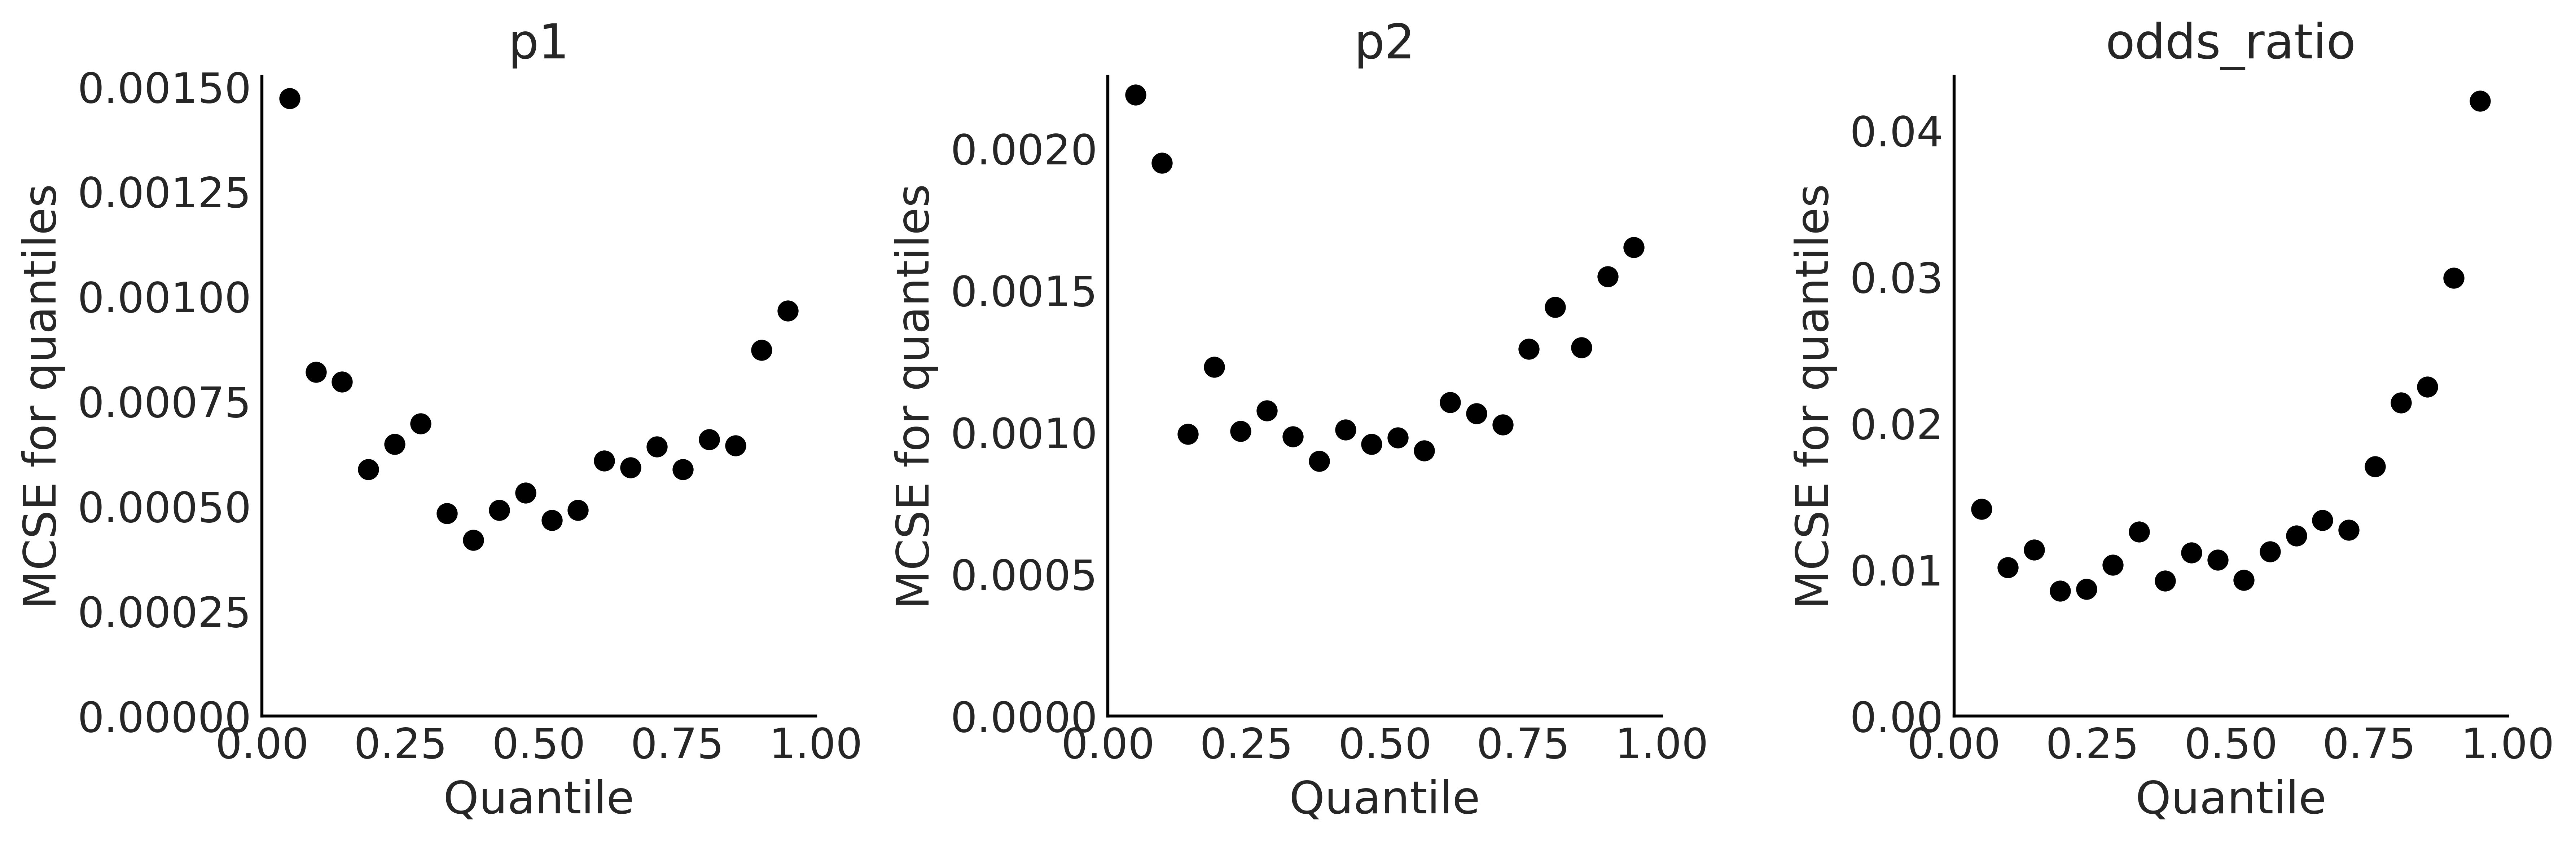

In [20]:
az.plot_mcse(trace, figsize=(12, 4))
plt.tight_layout()
plt.show();

### Autocorrelazione

L’autocorrelazione riduce la quantità effettiva di informazioni contenute in un campione e quindi è qualcosa che vogliamo mantenere al minimo. Possiamo ispezionare direttamente l’autocorrelazione con `az.plot_autocorr`.

/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_18260/722003944.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


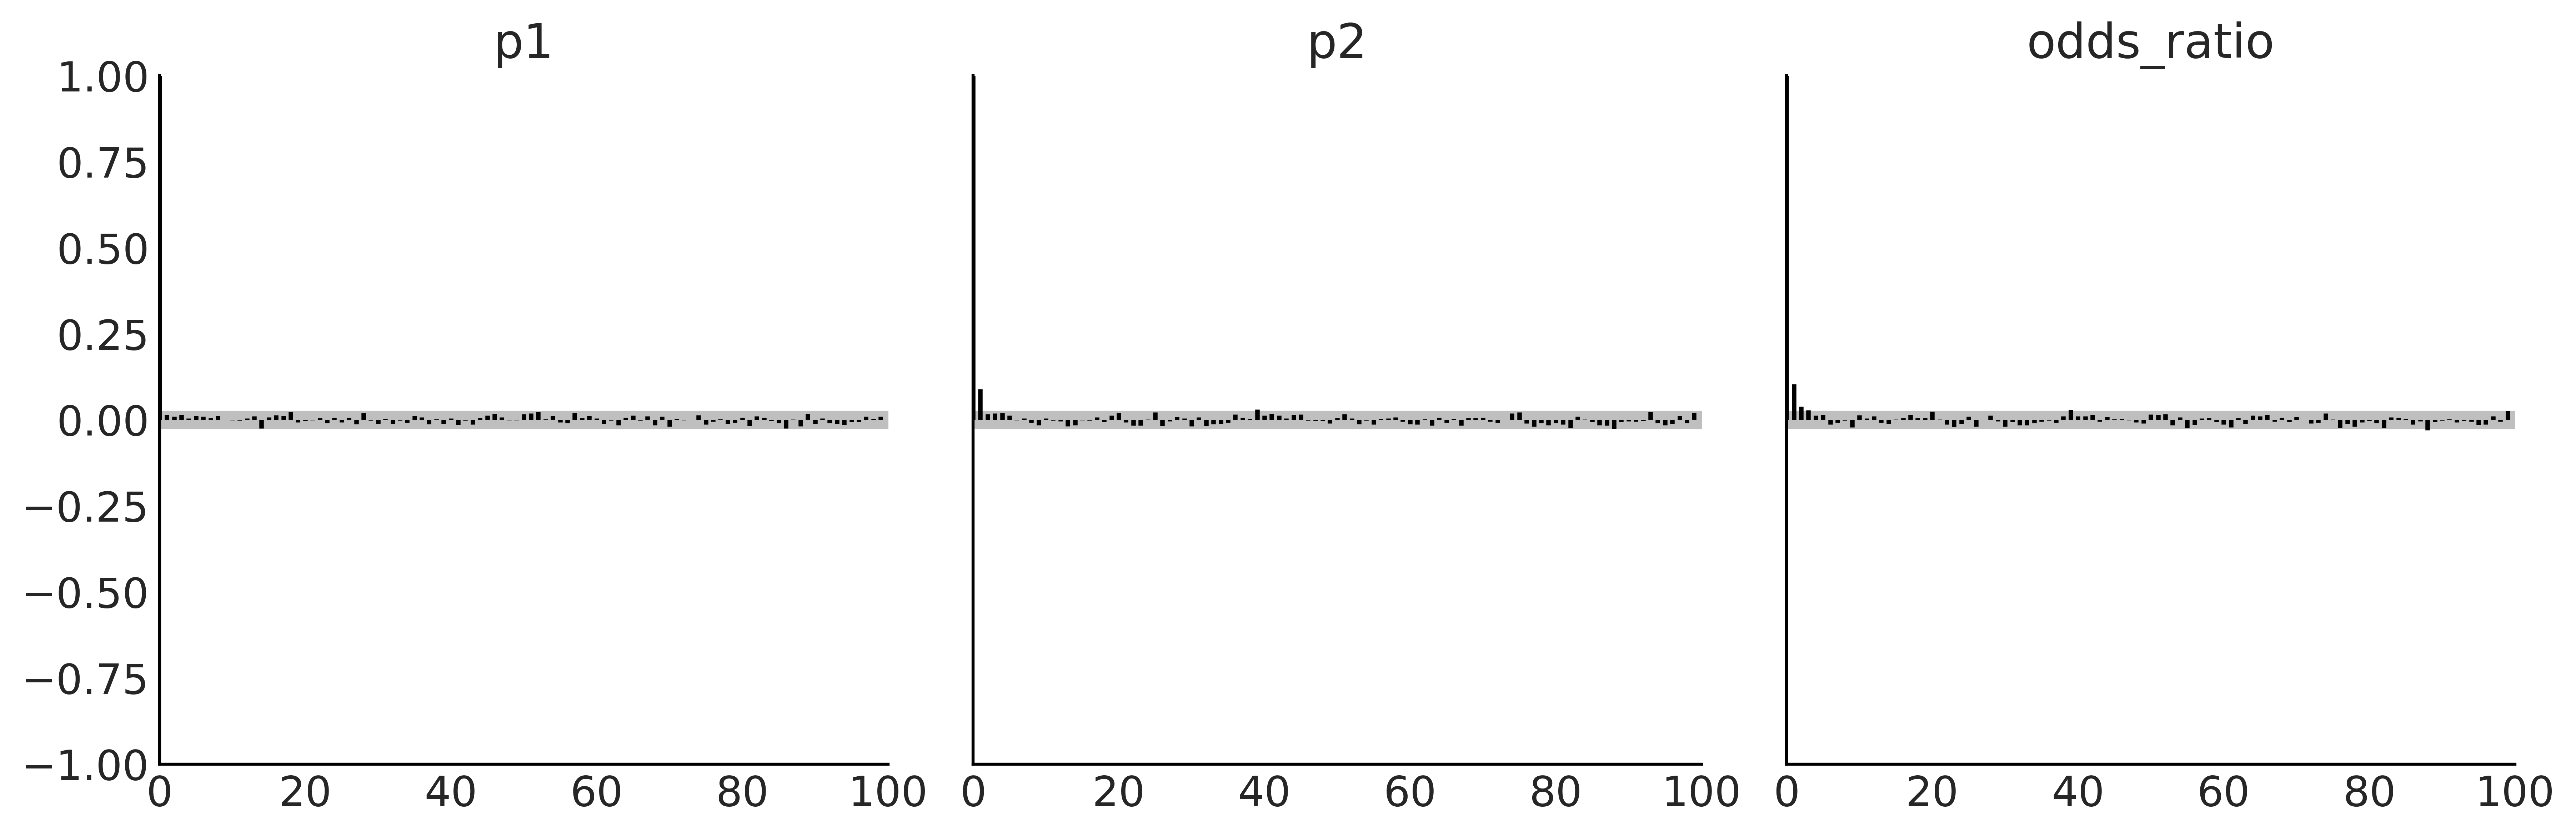

In [16]:
az.plot_autocorr(trace, combined=True, figsize=(12, 4))
plt.tight_layout()
plt.show()

### Rank Plots

I grafici dei ranghi sono un altro strumento diagnostico visivo che possiamo utilizzare per confrontare il comportamento del campionamento sia all’interno che tra le catene. I grafici dei ranghi, in parole semplici, sono istogrammi dei campioni della distribuzione a posteriori espressi in termini di ranghi. 

In statistica, il “rango” di un’osservazione è la sua posizione in un insieme di dati ordinati. Ad esempio, consideriamo il seguente insieme di dati: [5, 3, 8, 10]. Se ordiniamo questi dati in ordine crescente otterremo [3, 5, 8, 10]. In questo caso, il rango del numero 5 è 2 perché è il secondo numero nell’insieme ordinato. Allo stesso modo, il rango del numero 10 è 4 perché è il quarto numero nell’insieme ordinato.

Nei grafici dei ranghi, i ranghi sono calcolati combinando prima tutte le catene ma poi rappresentando i risultati separatamente per ogni catena. Se tutte le catene stimano la stessa distribuzione, ci aspettiamo che i ranghi abbiano una distribuzione uniforme. Inoltre, se i grafici dei ranghi di tutte le catene sembrano simili, ciò indica un buon mix delle catene.

Possiamo ottenere i grafici dei ranghi con `az.plot_rank`.

/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_18260/3264935189.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


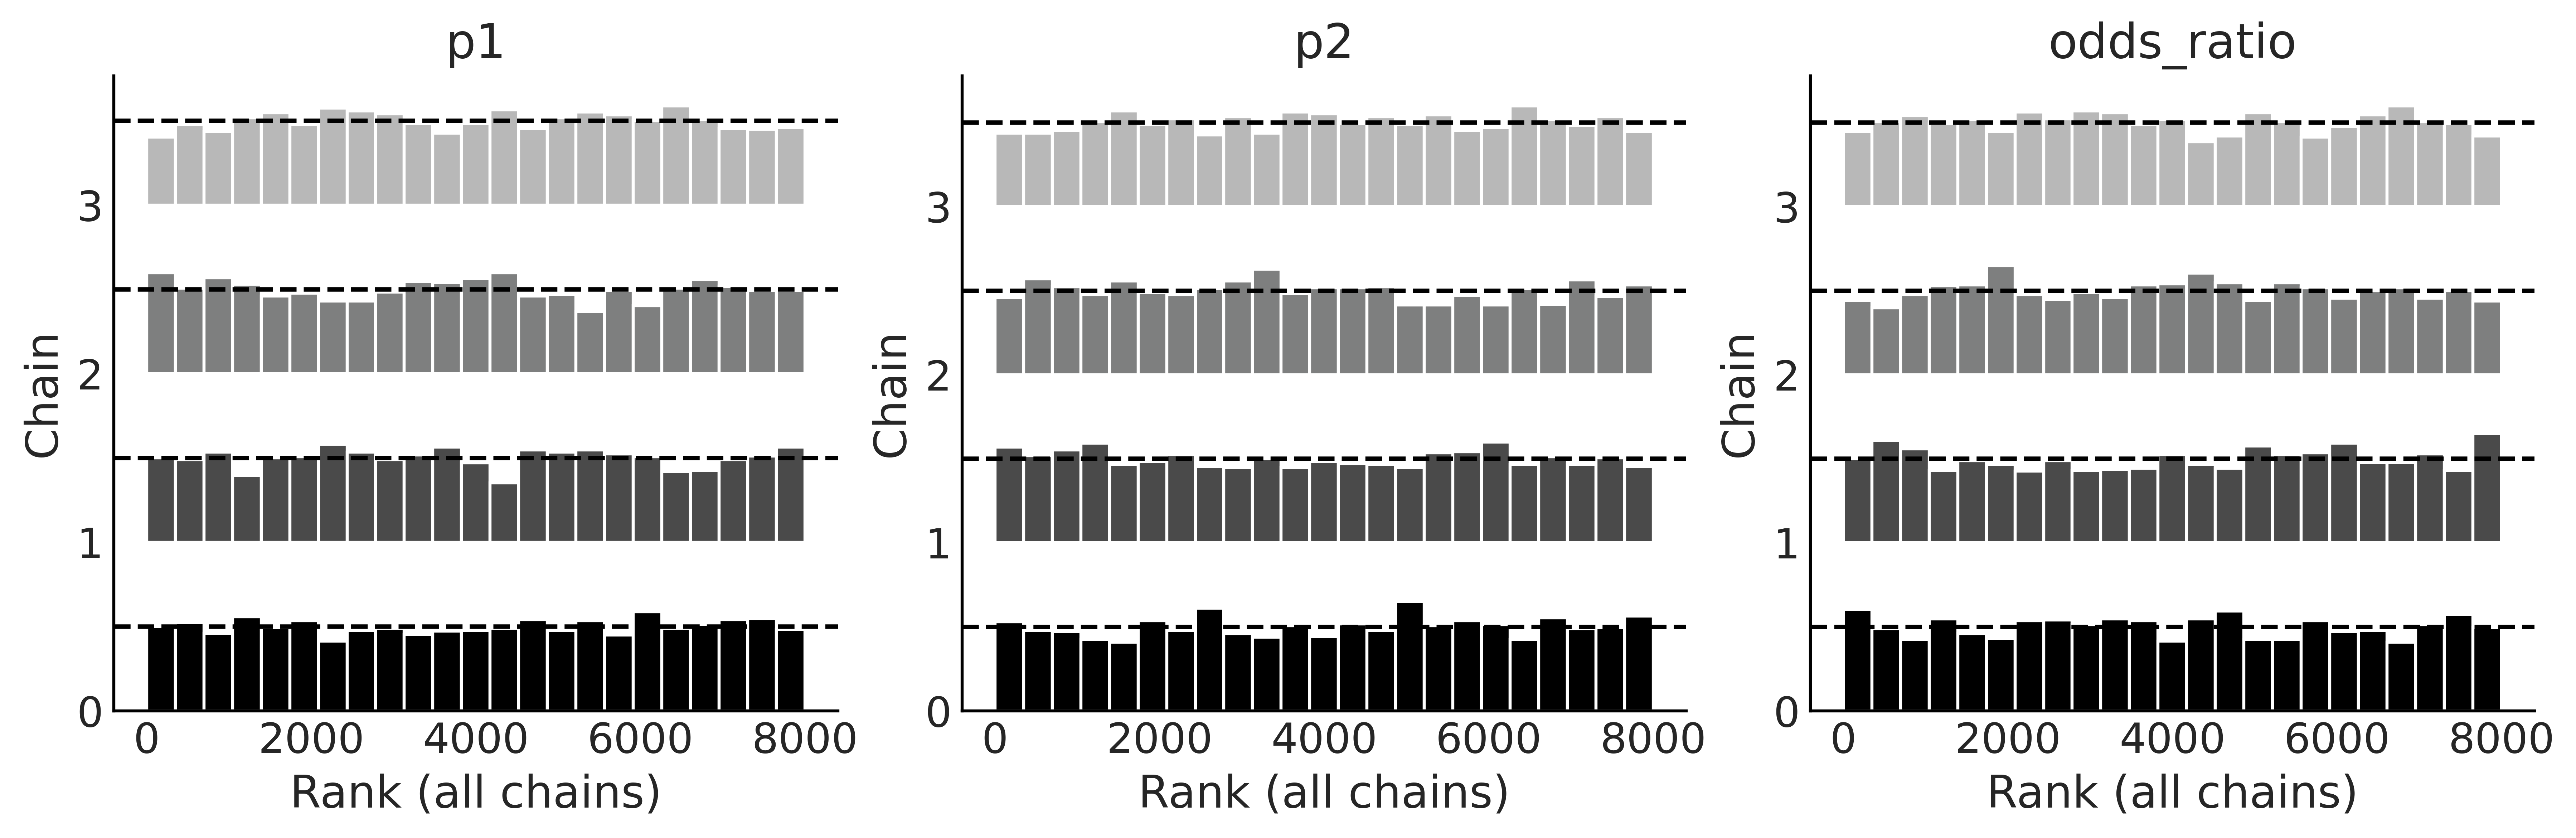

In [17]:
az.plot_rank(trace, kind="bars", figsize=(12, 4))
plt.tight_layout()
plt.show()

Una rappresentazione alternativa è la seguente.

/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_18260/4260078185.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


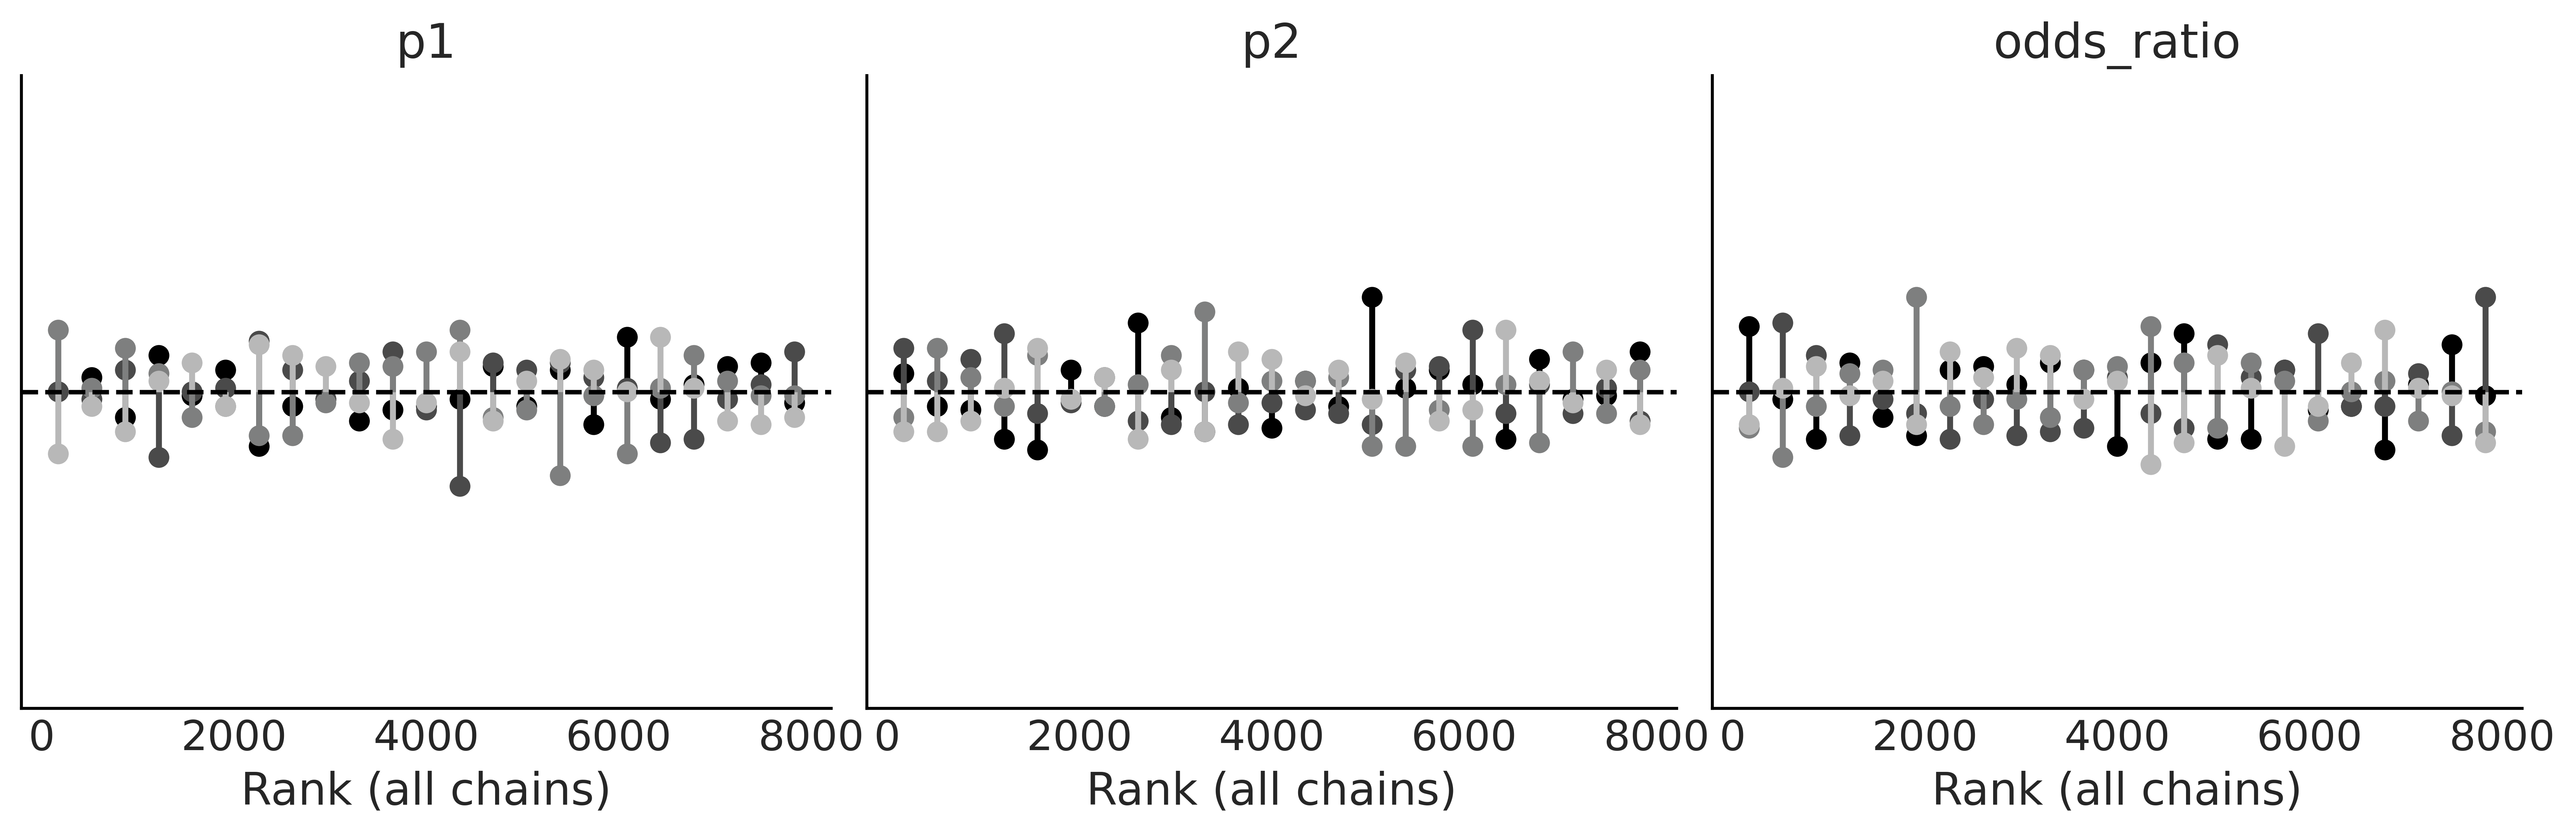

In [18]:
az.plot_rank(trace, kind="vlines", figsize=(12, 4))
plt.tight_layout()
plt.show()

Possiamo vedere nella figura che i ranghi sono molto simili ad una distribuzione uniforme e che tutte le catene sono simili tra loro senza alcuno scostamento distintivo.

### Divergenza

Finora abbiamo diagnosticato il funzionamento di un campionatore esaminando i campioni generati. Un altro modo per eseguire una diagnosi è monitorare il comportamento dei meccanismi interni del metodo di campionamento. Un esempio importante di tali diagnosi è il concetto di divergenza presente in alcuni metodi Hamiltonian Monte Carlo (HMC). Le divergenze (o transizioni divergenti) sono un modo potente e sensibile per diagnosticare i campioni e funzionano come complemento alle diagnosi che abbiamo visto nelle sezioni precedenti. 

PyMC riporta il numero di transizioni divergenti. Se non viene riportato alcun messaggio che informa della presenza di transizioni divergenti, questo vuol dire che la distribuzione a posteriori è stata stimata correttamente.

## Risultati

Dato i risultati della diagnostica delle catene markoviane non rivelano alcun problema con la convergenza dell'algoritmo o con il modello statistico esaminato, passiamo ad esaminare i risultati.

In [16]:
az.summary(trace, hdi_prob=0.90, round_to=3)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p1,0.692,0.037,0.634,0.754,0.000,0.000,7969.522,5917.510,1.000
p2,0.492,0.065,0.383,0.595,0.001,0.001,8364.979,5706.749,1.001
odds_ratio,2.452,0.803,1.204,3.632,0.009,0.007,8066.302,5713.012,1.000


Si noti il valore di $\hat{R}$ che, al massimo, raggiunge il valore di 1.001.  Questa è la più importante statistica di convergenza dell'algoritmo MCMC.  Essendo il valore molto simile a 1 nel caso presente, possiamo dire che non ci sono evidenza di assenza di convergenza.

Il valore ESS_BULK non fornisce alcuna evidenza di cattivo mixing. Infatti, il valore è adirittura superiore al valore di  $N$ = 8000 che è il numero di campioni che sono stati estratti dalla distribuzione a posteriori. Emerge un problema di mixing se ESS_BULK è minore ad 1/10 di $N$, il che non è il caso qui.

L'errore standard di Monte Carlo ci informa della precisione della stima ottenuta usando il metodo MCMC. Non possiamo riportare una precisione dei risultati maggiore di quella indicata dalla MCSE. Quindi, nel caso presente per l'OR direi che due cifre decimali sono il massimo che si può fare.

### Conclusione

In questo capitolo, ci siamo concentrati sull'inferenza bayesiana riguardante l'odds-ratio. Dall'analisi dei dati, abbiamo ottenuto una stima a posteriori dell'OR pari a 2.45, con un intervallo di credibilità al 90% compreso tra 1.29 e 3.67. L'importante risultato è che l'intervallo di credibilità per l'odds-ratio (OR) non include il valore 1. Questo ci permette di concludere con un grado di certezza soggettiva del 90% che le studentesse tendono ad impiegare un tempo maggiore della media rispetto agli studenti maschi.

Va comunque sottolineato che, per affrontare questo problema, sarebbe stato più appropriato confrontare direttamente i tempi impiegati dalle studentesse e dagli studenti maschi, utilizzando una procedura di confronto tra le medie di campioni indipendenti. Questo approccio avrebbe fornito informazioni dirette sulla differenza di tempo tra i due gruppi.

Tuttavia, abbiamo scelto di procedere con l'analisi inferenziale bayesiana sull'odds-ratio per dimostrare come eseguire questo tipo di analisi e per comprenderne l'utilità nel confrontare le proporzioni tra gruppi. L'approccio bayesiano ci ha consentito di valutare la credibilità dell'effetto osservato e di comprendere se la differenza tra i gruppi è una caratteristica generale o specifica solo del nostro campione. Questo ci ha fornito una prospettiva più generale sul fenomeno e sulla sua interpretazione probabilistica. L'analisi bayesiana ci ha inoltre permesso di integrare conoscenze a priori con l'evidenza dai dati per ottenere una stima più accurata e robusta dell'odds-ratio.

## Esercizio 

Consideriamo un secondo evento dicotomico, ovvero il voto più alto, rappresentato da voti >= 30. Tra le studentesse, 15 su un totale di 155 hanno ottenuto voti >= 30. Mentre tra gli studenti maschi, 13 su un totale di 57 hanno ottenuto voti >= 30. Il problema richiede di calcolare l'odds ratio tra le probabilità di ottenere voti >= 30 tra le studentesse e gli studenti maschi, seguendo la procedura descritta in questo capitolo.

## Watermark

In [19]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Sep 06 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

arviz     : 0.16.1
scipy     : 1.11.2
matplotlib: 3.7.2
numpy     : 1.25.2
seaborn   : 0.12.2
pymc      : 5.7.2
pandas    : 2.1.0

Watermark: 2.4.3

